{{title_s1_5}}

So far in this tutorial, we've demonstrated how to read Sentinel-1 RTC imagery from two sources and assemble analysis-ready data cubes with appropriate metadata. Now, we'll perform a comparison of the two datasets. 

## Dataset comparison

While the two datasets are very similar, there are a few key differences:  
1) They use different sources images.   
    - ASF Sentinel-1 RTC imagery is processed from Single Look Complex ([SLC](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex)) images while Planetary Computer Sentinel-1 RTC imagery is processed from Ground Range Detected ([GRD](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected)) images. SLC images contain both amplitude and phase information for each pixel. They are in radar coordinates and have not yet been multi-looked. In contrast, GRD images has been detected, multi-looked and projected to ground range.

2) They use different digital elevation models (DEMs) for terrain correction.  
    - ASF uses the [GLO-30 Copernicus DEM](https://dataspace.copernicus.eu/explore-data/data-collections/copernicus-contributing-missions/collections-description/COP-DEM) while Planetary Computer uses a Planet DEM.  
3) The datasets have different pixel spacings. For Planetary Computer, the pixel spacing is 10m in both range and azimuth directions. ASF has the option to produce images with 30 m, 20 m, or 10 m pixel spacaing. The data used in this tutorial is 30 m. Note that there are tradeoffs in processing time and file size with pixel spacing, see more discussion [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#pixel-spacing_1).  
4) Each platform uses a different algorithm for RTC processing.
5) The ASF dataset comes with an associated layover shadow map for each scene while the Planetary Computer dataset does not.  

All of the above information and much more detail about the processing methods for both datasets are available in each dataset's documentation pages:
- [ASF Sentinel-1 RTC Product Guide](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#pixel-spacing_1)  
- [Microsoft Planetary Computer Sentinel-1 RTC dataset](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc)  

::::{tab-set}
:::{tab-item} Outline

:::
:::{tab-item} Learning goals

:::
::::
## Learning goals

**Xarray and python techniques:**
- Conditional selection based on non-dimensional coordinates using `xr.Dataset.where()`
- Subsetting datasets based on dimensional coordinates using `xr.DataArray.isin()`
- Adding dimensional and non-dimensional coordinates to `xr.Dataset` objects
- Xarray plotting methods
- Projecting xarray objects to different grids using `xr.interp_like()`

**High-level science goals**
- Comparing and evaluating multiple datasets
- Setting up multiple datasets for direct comparisons
- Handling differences in spatial resolution 

In [1]:
%xmode minimal
import dask.distributed
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import stackstac
import xarray as xr
import pystac
import planetary_computer

from dask.distributed import Client

import s1_tools

%matplotlib inline

Exception reporting mode: Minimal


## A. Read and prepare data

At the end of notebook 3, we wrote the analysis-ready ASF Sentinel-1 data cube that had been clipped to a smaller spatial area of interest to disk. We'll read that into memory now to use in this comparison.

(old)The Planetary Computer dataset is a bit larger. To avoid writing it to disk and since there is less processing needed to prepare it for analysis, we'll read it again like in notebook 4. 

We used Jupyter cell magic to persist the Planetary Computer data cube created in noteboook 4. Now we can read it into our notebook by adding `-r` to the store magic command used to persist it. Read more about `storemagic` [here](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html).

In [2]:
%store -r da
pc_cube = da

#old
#Create PC data cube
#time_range = "2021-05-02/2022-05-21"
#bbox = [88.214935, 27.92767, 88.302, 28.034]
#epsg = 32645

#pc_data_cube = s1_tools.S1PC_DataCube(time_range, bbox, epsg)
#pc_data_cube = pc_data_cube.da.compute()

In [86]:
#old
#above not working so reading pc cube for now
#pc_cube_path = '../data/s1_pc_cube.zarr'

#pc_cube = xr.open_dataset(pc_cube_path, chunks='auto',engine='zarr')
#pc_data_cube = pc_data_cube.da.compute()

In [99]:
# Create ASF data cube
#cwd = pathlib.Path.cwd()
#tutorial2_dir = pathlib.Path(cwd).parent

#vv_vrt_path = "../data/vrt_files/s1_stackVV.vrt"
#vh_vrt_path = "../data/vrt_files/s1_stackVH.vrt"
#ls_vrt_path = "../data/vrt_files/s1_stackLS.vrt"

#asf_cube = s1_tools.metadata_processor(
#    vv_path=vv_vrt_path, vh_path=vh_vrt_path, ls_path=ls_vrt_path
#)

In [3]:
asf_cube = xr.open_dataset('../data/s1_asf_clipped_cube.zarr',
                           engine='zarr',chunks='auto').compute()

### {{a1_s1_nb5}}

First, make sure that both objects are projected to the same CRS.

In [4]:
assert pc_cube.rio.crs == asf_cube.rio.crs, 'CRS of both data cubes are expected to be identical.'

Let's also check how mising data is handled in both objects. We want missing data to be assigned NaN values.

In [5]:
asf_cube['vv'].rio.nodata

nan

In [6]:
pc_cube.sel(band='vv').rio.nodata

The `pc_cube` array contains nan values, but it doesn't have an encoding specifying what value is used to represent nodata. We can assign a nodata value to the dataset below. See Rioxarray's [Nodata Management documentation](https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html) for more detail on this.

In [7]:
pc_cube.rio.write_nodata(np.nan, inplace=True)
pc_cube.rio.nodata

nan

In [8]:
assert np.isnan(asf_cube.vh.rio.nodata) == np.isnan(pc_cube.sel(band='vh').rio.nodata) == True, 'Expected vh nodata value to be np.nan'
assert np.isnan(asf_cube.vv.rio.nodata) == np.isnan(pc_cube.sel(band='vv').rio.nodata) == True, 'Expected vv nodata value to be np.nan'

## B. Extract common data take IDs from both cubes

Both objects have temporal dimensions with the same length, so we can be reasonably sure that these two objects have common acquisitions but we can do a few more things to be sure about that. 

Thanks to all of the metadata wrangling we did in earlier notebooks, we can quickly access variables like acquisition date and time, data take IDs and absolute orbit numbers to verify that the we're working with comparable objects.

### 1) Ensure orbit numbers of both objects identical

If we try to compare orbit numbers right away (eg: `asf_cube['abs_orbit_num'].data == pc_cube['sat:absolute_orbit']`), we will get that they are false. This is because the data in the underlying numpy arrays is currently not of the same type:

In [9]:
print(asf_cube['abs_orbit_num'].data.dtype)
print(pc_cube['sat:absolute_orbit'].data.dtype)

<U6
int64


Convert the absolute orbit array of `asf_cube` to an array of integers:

In [10]:
asf_cube['abs_orbit_num'] = asf_cube['abs_orbit_num'].astype(int)
                                                             

Now compare them:

In [11]:
asf_cube['abs_orbit_num'].data == pc_cube['sat:absolute_orbit'].data

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

We can also compare the granule IDs. Somewhat confusingly, the PC dataset's `s1:datatake_id` variable doesn't seem to match the `'data_take_ID'` variable from the ASF dataset. However, the PC datacube has another coordinate, `'id'`, that contains the full source granule. We can access the data take ID from this the same way we did for the ASF dataset in the metadata wrangling [notebook](2_wrangle_metadata.ipynb).

## C. Combine objects

In [ ]:
asf_cube = asf_cube.rename({'acq_date':'time'})


In [46]:

combined_vv = xr.combine_by_coords([asf_cube['vv'], 
                                    pc_cube.sel(band='vv')])

ValueError: cannot rename 'vv' because it is not a variable or dimension in this dataset

In [45]:
combined_vv

<xarray.Dataset> Size: 5GB
Dimensions:                                     (time: 192, x: 1178, y: 1938)
Coordinates: (12/44)
  * time                                        (time) datetime64[ns] 2kB 202...
  * x                                           (x) float64 9kB 6.194e+05 ......
  * y                                           (y) float64 16kB 3.09e+06 ......
    id                                          (time) object 2kB 'S1A_IW_GRD...
    band                                        <U2 8B 'vv'
    constellation                               <U10 40B 'Sentinel-1'
    ...                                          ...
    epsg                                        int64 8B 32645
    abs_orbit_num                               (time) float64 2kB nan ... nan
    data_take_ID                                (time) object 2kB nan ... nan
    orbital_dir                                 (time) object 2kB nan ... nan
    product_id                                  (time) object 2kB nan ... nan
    spatial_ref                                 int64 8B 0
Data variables:
    stackstac-7d5919d6da5b735386e3f1c300961729  (time, y, x) float64 4GB 0.06...
    vv                                          (time, y, x) float32 2GB nan ...

In [41]:
combined_vh

<xarray.Dataset> Size: 3GB
Dimensions:                                (acq_date: 96, x: 1178, y: 1938,
                                            time: 96)
Coordinates: (12/45)
  * acq_date                               (acq_date) datetime64[ns] 768B 202...
  * x                                      (x) float64 9kB 6.194e+05 ... 6.28...
  * y                                      (y) float64 16kB 3.09e+06 ... 3.10...
    abs_orbit_num                          (acq_date) int64 768B 37709 ... 43309
    data_take_ID                           (acq_date) <U6 2kB '047321' ... '0...
    orbital_dir                            (acq_date) <U4 2kB 'desc' ... 'desc'
    ...                                     ...
    sar:pixel_spacing_azimuth              int64 8B 10
    s1:datatake_id                         (time) <U6 2kB '291617' ... '338944'
    title                                  <U41 164B 'VH: vertical transmit, ...
    description                            <U173 692B 'Terrain-corrected gamm...
    raster:bands                           object 8B {'nodata': -32768, 'data...
    epsg                                   int64 8B 32645
Data variables:
    asf                                    (acq_date, y, x) float32 877MB nan...
    pc                                     (time, y, x) float64 2GB 0.03485 ....

## Visual comparison

Let's perform some preliminary visual comparisons of the datasets:

#### Individual time steps

Use `asf_bc_sidebyside()` to compare snapshot views of backscatter at individual time steps:

In [ ]:
pc_subset

In [17]:
pc_ds = pc_cube.to_dataset(dim='band')

In [37]:
def asf_pc_sidebyside(asf_input:xr.Dataset, 
                      pc_input:xr.Dataset, 
                      timestep:int, 
                      band:str):
    fig, axs = plt.subplots(ncols=2, figsize=(15, 10))

    s1_tools.power_to_db(asf_input[f'{band}'].isel(acq_date=timestep)).plot(
        ax=axs[0], cmap=plt.cm.Greys_r, label="ASF"
    )
    s1_tools.power_to_db(pc_input[f'{band}'].isel(time=timestep)).plot(
        ax=axs[1], cmap=plt.cm.Greys_r, label="PC"
    )
    date = asf_cube.isel(acq_date=timestep)['acq_date'].dt.date.data
    fig.suptitle(f'Comparing ASF and Planetary Computer Sentinel-1 RTC {band.upper()} backscatter at {date}.')
    axs[0].set_title('ASF')
    axs[1].set_title('Planetary Computer')


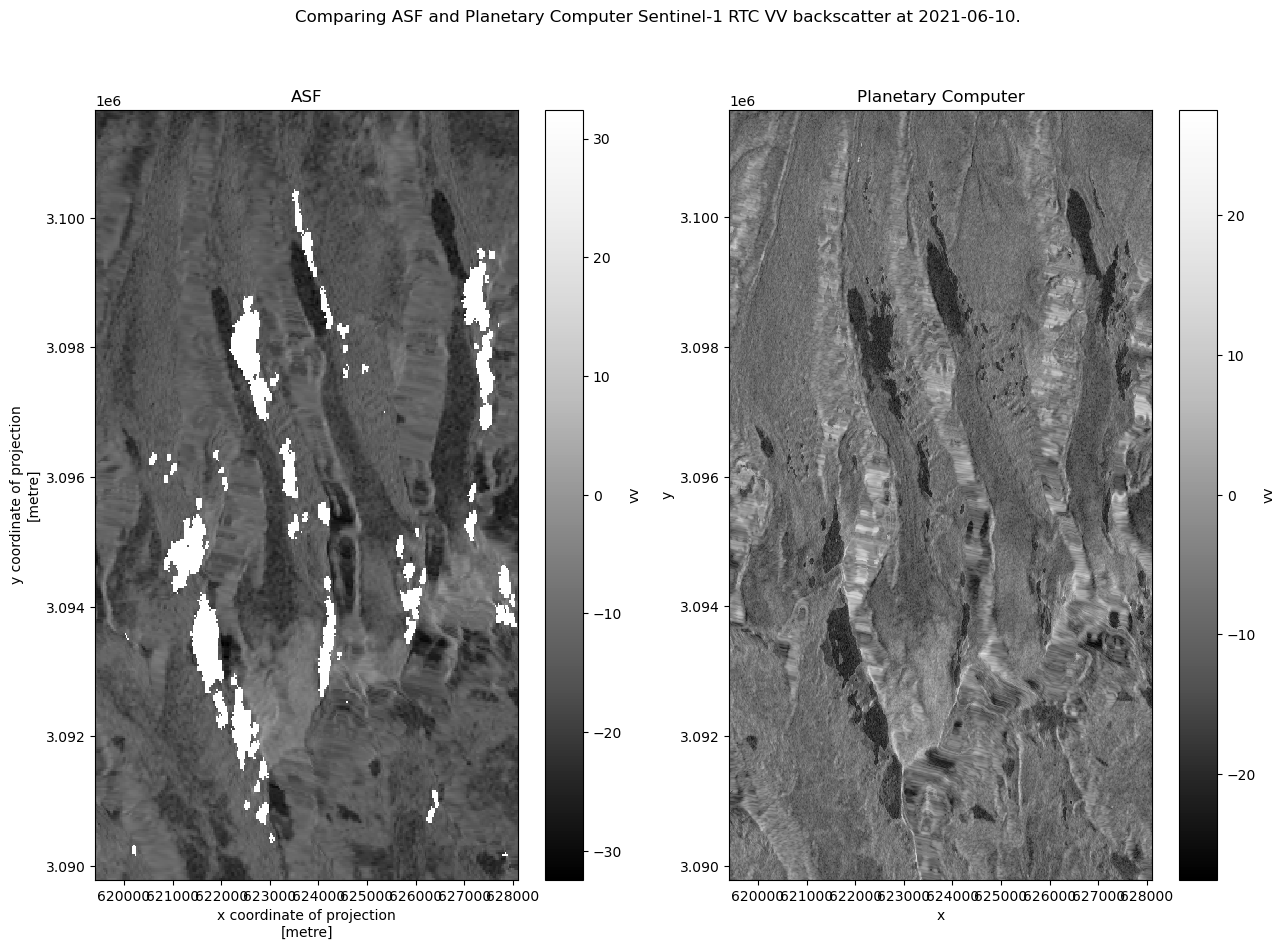

In [38]:
asf_pc_sidebyside(asf_cube, pc_ds, 10, 'vv')

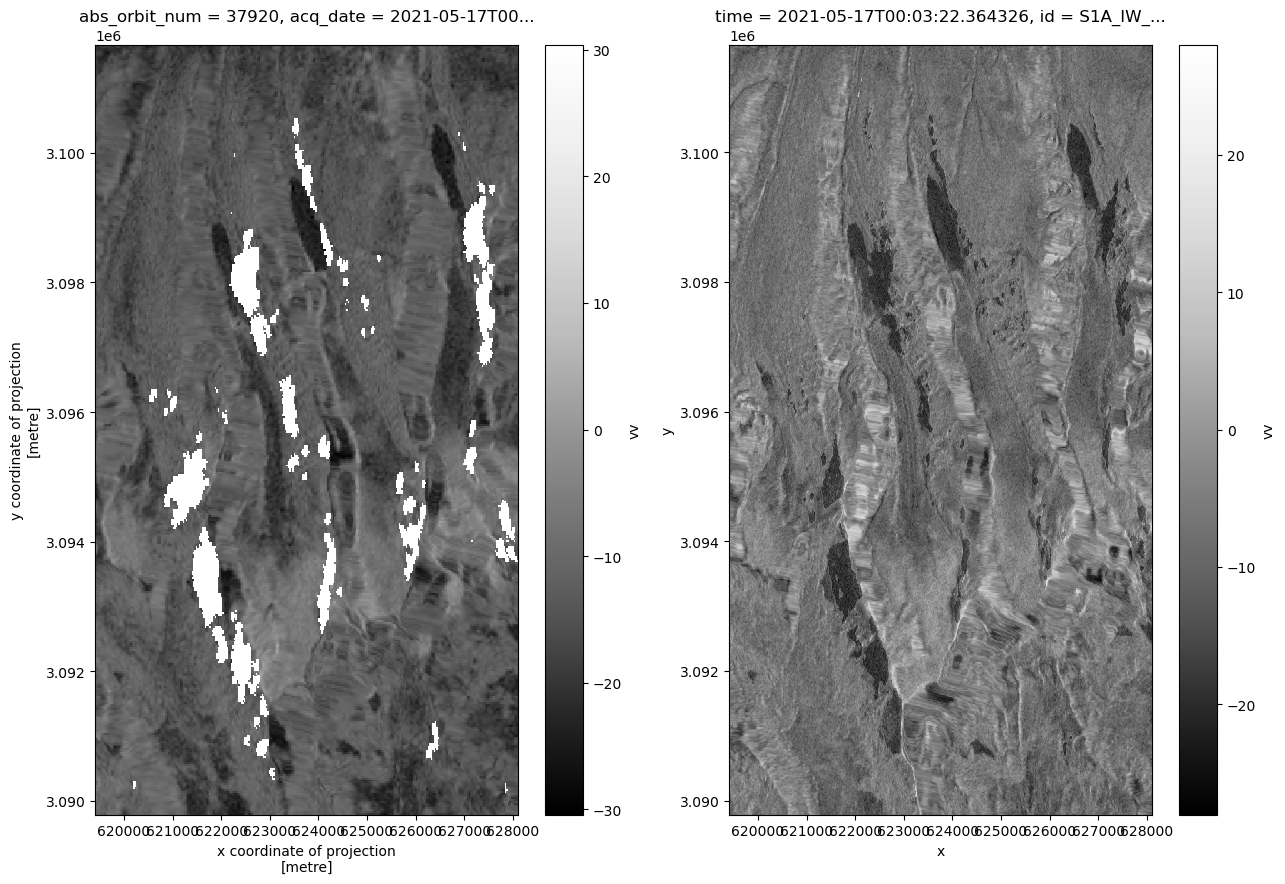

In [17]:
s1_tools.asf_pc_sidebyside(asf_cube, pc_ds, 4)

### Average backscatter over time

Now we will look at the backscatter mean along the time dimension

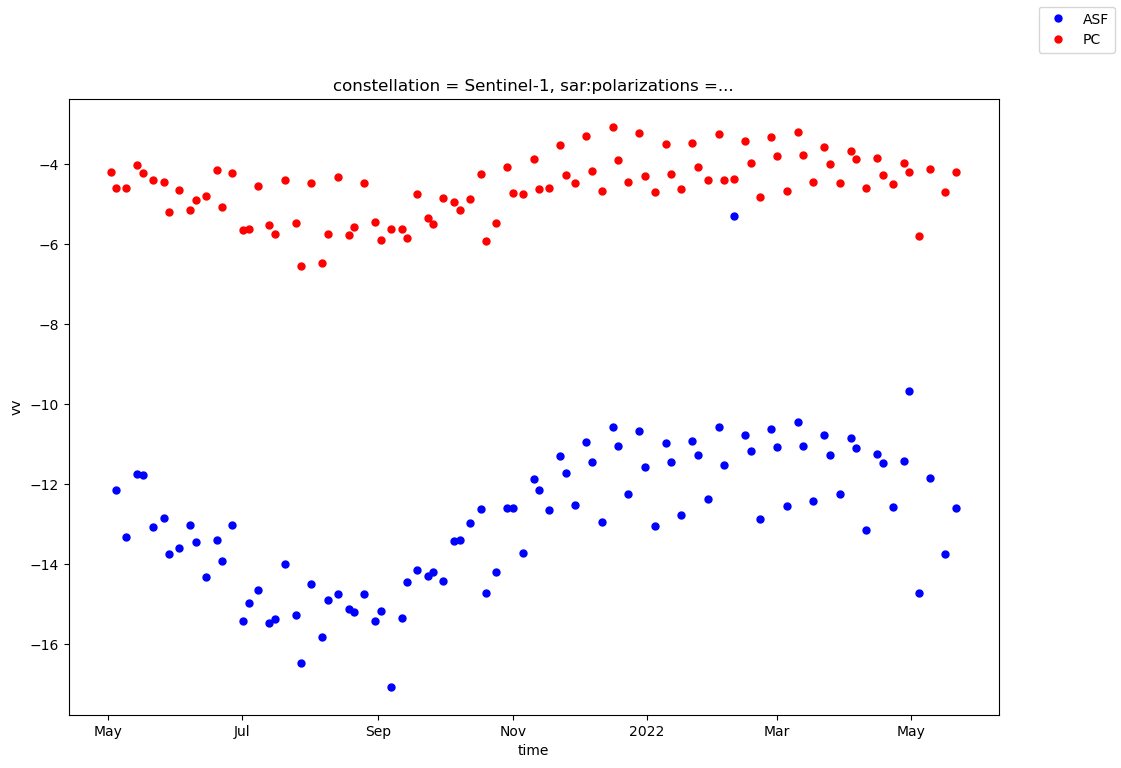

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

s1_tools.power_to_db(asf_cube.vv.mean(dim=["x", "y"])).plot(
    ax=ax, color="blue", linestyle="None", marker="o", markersize=5, label="ASF"
)
s1_tools.power_to_db(pc_ds.vv.mean(dim=["x", "y"])).plot(
    ax=ax, color="red", linestyle="None", marker="o", markersize=5, label="PC"
)
fig.legend();

## Handling spatial resolution differences

The PC dataset has a higher spatial resolution than the ASF dataset, which you can see in the sizes of the x and y dimensions of the dataset. The ASF dataset masks out more pixels due to shadow than the PC dataset. To explore whether or not this is the cause of the observed backscatter offset between the two, we need to mask out the pixels in the PC dataset that are masked in the ASF dataset. 

In order to do this, first we must downsample the PC dataset to match the spatial resolution of the ASF dataset. There are multiple xarray methods that could be used but here we will use the `xr.interp_like()` method because we would like the PC x and y dimensions to match the ASF dimensiosn exactly. 

In [19]:
asf_cube = asf_cube.rename({"acq_date": "time"})

In [20]:
asf_cube.time

<xarray.DataArray 'time' (time: 96)> Size: 768B
array(['2021-05-02T12:14:14.000000000', '2021-05-05T00:03:07.000000000',
       '2021-05-09T12:05:42.000000000', '2021-05-14T12:13:49.000000000',
       '2021-05-17T00:03:08.000000000', '2021-05-21T12:05:43.000000000',
       '2021-05-26T12:13:50.000000000', '2021-05-29T00:03:09.000000000',
       '2021-06-02T12:05:43.000000000', '2021-06-07T12:13:51.000000000',
       '2021-06-10T00:03:10.000000000', '2021-06-14T12:05:44.000000000',
       '2021-06-19T12:13:52.000000000', '2021-06-22T00:03:10.000000000',
       '2021-06-26T12:05:45.000000000', '2021-07-01T12:13:52.000000000',
       '2021-07-04T00:03:11.000000000', '2021-07-08T12:05:45.000000000',
       '2021-07-13T12:13:53.000000000', '2021-07-16T00:03:12.000000000',
       '2021-07-20T12:05:46.000000000', '2021-07-25T12:13:54.000000000',
       '2021-07-28T00:03:12.000000000', '2021-08-01T12:05:47.000000000',
       '2021-08-06T12:13:54.000000000', '2021-08-09T00:03:13.000000000',
       '2021-08-13T12:05:48.000000000', '2021-08-18T12:13:55.000000000',
       '2021-08-21T00:03:14.000000000', '2021-08-25T12:05:48.000000000',
       '2021-08-30T12:13:56.000000000', '2021-09-02T00:03:14.000000000',
       '2021-09-06T12:05:49.000000000', '2021-09-11T12:13:56.000000000',
       '2021-09-14T00:03:15.000000000', '2021-09-18T12:05:49.000000000',
       '2021-09-23T12:13:57.000000000', '2021-09-26T00:03:15.000000000',
       '2021-09-30T12:05:50.000000000', '2021-10-05T12:13:57.000000000',
       '2021-10-08T00:03:15.000000000', '2021-10-12T12:05:50.000000000',
       '2021-10-17T12:13:57.000000000', '2021-10-20T00:03:16.000000000',
       '2021-10-24T12:05:50.000000000', '2021-10-29T12:13:57.000000000',
       '2021-11-01T00:03:15.000000000', '2021-11-05T12:05:49.000000000',
       '2021-11-10T12:13:57.000000000', '2021-11-13T00:03:15.000000000',
       '2021-11-17T12:05:49.000000000', '2021-11-22T12:13:56.000000000',
       '2021-11-25T00:03:15.000000000', '2021-11-29T12:05:49.000000000',
       '2021-12-04T12:13:56.000000000', '2021-12-07T00:03:14.000000000',
       '2021-12-11T12:05:48.000000000', '2021-12-16T12:13:55.000000000',
       '2021-12-19T00:03:14.000000000', '2021-12-23T12:05:48.000000000',
       '2021-12-28T12:13:55.000000000', '2021-12-31T00:03:13.000000000',
       '2022-01-04T12:05:47.000000000', '2022-01-09T12:13:54.000000000',
       '2022-01-12T00:03:13.000000000', '2022-01-16T12:05:47.000000000',
       '2022-01-21T12:13:54.000000000', '2022-01-24T00:03:12.000000000',
       '2022-01-28T12:05:46.000000000', '2022-02-02T12:13:53.000000000',
       '2022-02-05T00:03:12.000000000', '2022-02-09T12:05:46.000000000',
       '2022-02-14T12:13:53.000000000', '2022-02-17T00:03:11.000000000',
       '2022-02-21T12:05:46.000000000', '2022-02-26T12:13:53.000000000',
       '2022-03-01T00:03:11.000000000', '2022-03-05T12:05:45.000000000',
       '2022-03-10T12:13:53.000000000', '2022-03-13T00:03:11.000000000',
       '2022-03-17T12:05:45.000000000', '2022-03-22T12:13:53.000000000',
       '2022-03-25T00:03:12.000000000', '2022-03-29T12:05:46.000000000',
       '2022-04-03T12:13:53.000000000', '2022-04-06T00:03:12.000000000',
       '2022-04-10T12:05:46.000000000', '2022-04-15T12:13:53.000000000',
       '2022-04-18T00:03:12.000000000', '2022-04-22T12:05:47.000000000',
       '2022-04-27T12:13:54.000000000', '2022-04-30T00:03:13.000000000',
       '2022-05-04T12:05:47.000000000', '2022-05-09T12:13:55.000000000',
       '2022-05-16T12:05:48.000000000', '2022-05-21T12:13:56.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    abs_orbit_num  (time) int64 768B 37709 37745 37811 ... 43134 43236 43309
  * time           (time) datetime64[ns] 768B 2021-05-02T12:14:14 ... 2022-05...
    data_take_ID   (time) <U6 2kB '047321' '047463' ... '0529DD' '052C00'
    orbital_dir    (time) <U4 2kB 'desc' 'asc' 'desc' ... 'desc' 'desc' 'desc'
    product_id     (time) <U4 2kB '1424' '54B1' '8A4F' ... '33F5' '7418' 'CA1B'
    spatial_r

In [21]:
pc_downsample = pc_ds.interp_like(asf_cube)

In [22]:
pc_downsample

<xarray.Dataset> Size: 176MB
Dimensions:                                (time: 96, y: 396, x: 290, band: 2)
Coordinates: (12/38)
    constellation                          <U10 40B 'Sentinel-1'
    sar:polarizations                      object 8B {'VH', 'VV'}
    sar:looks_azimuth                      int64 8B 1
    sar:looks_equivalent_number            float64 8B 4.4
    sar:resolution_azimuth                 int64 8B 22
    sar:product_type                       <U3 12B 'GRD'
    ...                                     ...
    s1:instrument_configuration_ID         (time) <U1 384B '6' '6' ... '7' '7'
    s1:total_slices                        (time) <U2 768B '20' '17' ... '20'
    s1:slice_number                        (time) <U2 768B '6' '12' ... '6' '6'
    s1:orbit_source                        (time) <U8 3kB 'DOWNLINK' ... 'RES...
    sat:orbit_state                        (time) <U10 4kB 'ascending' ... 'a...
    s1:datatake_id                         (time) <U6 2kB '291617' ... '338944'
Dimensions without coordinates: band
Data variables:
    vh                                     (time, y, x) float64 88MB 0.01178 ...
    vv                                     (time, y, x) float64 88MB 0.06035 ...
Attributes:
    spec:           RasterSpec(epsg=32645, bounds=(619419.5314582244, 3089781...
    crs:            epsg:32645
    transform:      | 9.79, 0.00, 619419.53|\n| 0.00,-7.70, 3101655.25|\n| 0....
    resolution_xy:  (9.788706070864338, 7.699930607059487)
    _FillValue:     nan

In [23]:
pc_mask = xr.where(asf_cube[["vh", "vv"]].notnull(), pc_downsample, np.nan)

In [24]:
pc_mask

<xarray.Dataset> Size: 176MB
Dimensions:                                (time: 96, y: 396, x: 290, band: 2)
Coordinates: (12/43)
    abs_orbit_num                          (time) int64 768B 37709 ... 43309
  * time                                   (time) datetime64[ns] 768B 2021-05...
    data_take_ID                           (time) <U6 2kB '047321' ... '052C00'
    orbital_dir                            (time) <U4 2kB 'desc' ... 'desc'
    product_id                             (time) <U4 2kB '1424' ... 'CA1B'
    spatial_ref                            int64 8B 0
    ...                                     ...
    s1:instrument_configuration_ID         (time) <U1 384B '6' '6' ... '7' '7'
    s1:total_slices                        (time) <U2 768B '20' '17' ... '20'
    s1:slice_number                        (time) <U2 768B '6' '12' ... '6' '6'
    s1:orbit_source                        (time) <U8 3kB 'DOWNLINK' ... 'RES...
    sat:orbit_state                        (time) <U10 4kB 'ascending' ... 'a...
    s1:datatake_id                         (time) <U6 2kB '291617' ... '338944'
Dimensions without coordinates: band
Data variables:
    vh                                     (time, y, x) float64 88MB nan ... nan
    vv                                     (time, y, x) float64 88MB nan ... nan

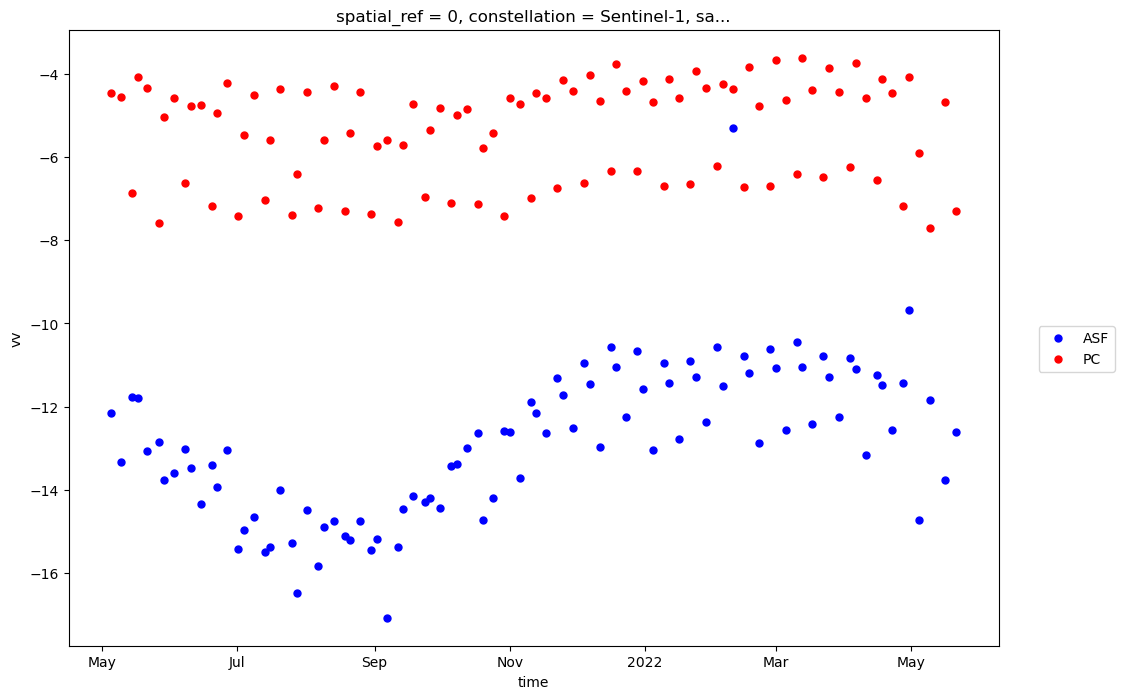

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))

s1_tools.power_to_db(asf_cube.vv.mean(dim=["x", "y"])).plot(
    ax=ax, color="blue", linestyle="None", marker="o", markersize=5, label="ASF"
)
s1_tools.power_to_db(pc_mask["vv"].mean(dim=["x", "y"], skipna=True)).plot(
    x="time", ax=ax, color="red", linestyle="None", marker="o", markersize=5, label="PC"
)
fig.legend(loc='center right');

## Break up by asc, desc pass


Use `xr.where()` to subset datasets by orbital pass:

In [ ]:
asf_subset

In [33]:
asf_desc = asf_cube.where(asf_cube["orbital_dir"] == "desc", drop=True)
asf_asc = asf_cube.where(asf_cube["orbital_dir"] == "asc", drop=True)

In [ ]:
# asf_asc.vv.mean(dim=['x','y']).plot(marker='o', linestyle='None')

In [51]:
pc_subset = pc_subset.compute()

In [37]:
pc_desc = pc_ds.where(pc_ds["sat:orbit_state"] == "descending", drop=True)
pc_asc = pc_ds.where(pc_ds["sat:orbit_state"] == "ascending", drop=True)

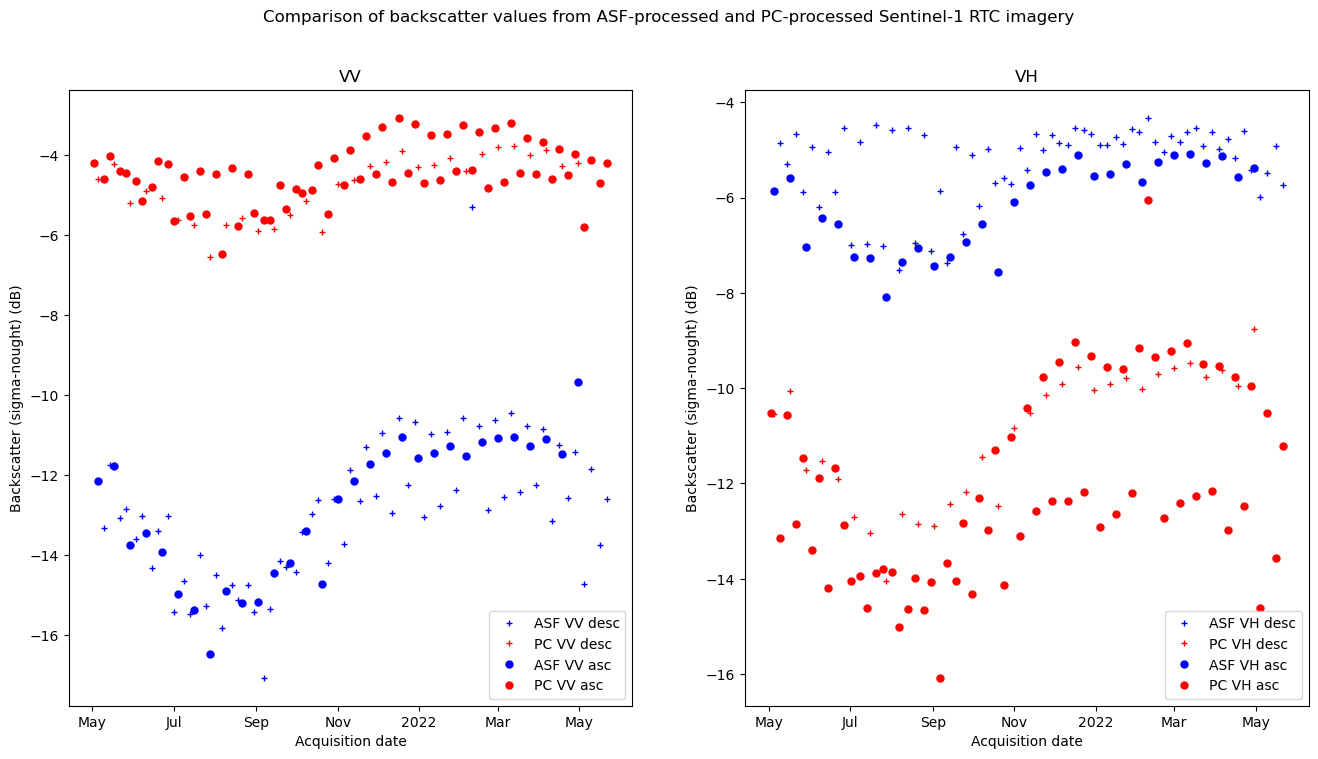

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

s1_tools.power_to_db(asf_desc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="blue",
    linestyle="None",
    marker="+",
    markersize=5,
    label="ASF VV desc",
)
s1_tools.power_to_db(pc_desc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="red",
    linestyle="None",
    marker="+",
    markersize=5,
    label="PC VV desc",
)
s1_tools.power_to_db(asf_asc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="blue",
    linestyle="None",
    marker="o",
    markersize=5,
    label="ASF VV asc",
)
s1_tools.power_to_db(pc_asc.vv.mean(dim=["x", "y"])).plot(
    ax=axs[0],
    color="red",
    linestyle="None",
    marker="o",
    markersize=5,
    label="PC VV asc",
)
axs[0].legend(loc="lower right")
axs[0].set_xlabel("Acquisition date")
axs[0].set_ylabel("Backscatter (sigma-nought) (dB)")
axs[0].set_title("VV")

s1_tools.power_to_db(asf_desc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="blue",
    linestyle="None",
    marker="+",
    markersize=5,
    label="ASF VH desc",
)
s1_tools.power_to_db(pc_desc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="red",
    linestyle="None",
    marker="+",
    markersize=5,
    label="PC VH desc",
)
s1_tools.power_to_db(asf_asc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="blue",
    linestyle="None",
    marker="o",
    markersize=5,
    label="ASF VH asc",
)
s1_tools.power_to_db(pc_asc.vh.mean(dim=["x", "y"])).plot(
    ax=axs[1],
    color="red",
    linestyle="None",
    marker="o",
    markersize=5,
    label="PC VH asc",
)
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Acquisition date")
axs[1].set_ylabel("Backscatter (sigma-nought) (dB)")
axs[1].set_title("VH")

fig.suptitle(
    "Comparison of backscatter values from ASF-processed and PC-processed Sentinel-1 RTC imagery"
);